In [2]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
!pip install langchain unstructured[all-docs] pydantic lxml openai faiss-cpu tiktoken opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 54.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.

In [1]:
!pip install langchain_community

  Using cached langchain_community-0.2.6-py3-none-any.whl (2.2 MB)


In [2]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.vectorstores import FAISS
from langchain.schema.messages import SystemMessage, HumanMessage
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [3]:
from google.colab import userdata

In [4]:
import time

In [5]:
openai_api_key = userdata.get('oai_api')

In [6]:
output_path = './images'

In [7]:
raw_pdf_elements = partition_pdf(
    filename = '/content/AC-Aids-for-Dogs_Canine-Periodontal-Disease.pdf',
    extract_images_in_pdf= True,
    infer_table_structure= True,
    chunking_strategy= 'by_title',
    max_characters = 4000,
    new_after_n_chars = 3800,
    combine_text_after_n_chars = 2000,
    extract_image_block_output_dir= output_path,
)

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.

In [8]:
text_elements = []
table_elements = []
text_summaries = []
table_summaries = []

summary_prompt= """
Summarize the following {element_type}: {element}
"""

In [9]:
summary_chain = LLMChain(
    llm = ChatOpenAI(model = 'gpt-3.5-turbo', openai_api_key = openai_api_key, max_tokens = 1024),
    prompt = PromptTemplate.from_template(summary_prompt)
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [10]:
for e in raw_pdf_elements:
  if 'CompositeElement' in repr(e):
    text_elements.append(e.text)
    summary = summary_chain.run({'element_type': 'text', 'element': e })
    text_summaries.append(summary)
  elif 'Table' in repr(e):
    table_elements.append(e.text)
    summary = summary_chain.run({'element_type': 'table', 'element': e })
    table_summaries.append(summary)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [11]:
# get image summary
image_elements = []
image_summaries = []
def encode_image(image_path):
  with open(image_path, 'rb') as f:
    return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
  prompt = [
      SystemMessage(content="You are a bot that is good at analyzing images related with Dog's health."),
      HumanMessage(content= [
          {"type": "text",
           "text": "Describe the contents of this image"
           },
          {"type" : "image_url",
           "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"},
           }
      ])
  ]
  response = ChatOpenAI(model="gpt-4o", openai_api_key = openai_api_key, max_tokens = 1064).invoke(prompt)
  return response.content

for i in os.listdir(output_path):
  if i.endswith(('.png', '.jpg', '.jpeg')):
    image_path = os.path.join(output_path, i)
    encoded_image = encode_image(image_path)
    image_elements.append(encoded_image)
    summary = summarize_image(encoded_image)
    image_summaries.append(summary)


In [12]:
# creating documents and vectorstore
documents = []
retrieve_contents = []
for e, s in zip(text_elements, text_summaries):
  i = str(uuid.uuid4())
  doc = Document(page_content= s,
                 metadata={'id': i,
                           'type': 'text',
                           'original_content': e})
  retrieve_contents.append((i,e))
  documents.append(doc)

for e, s in zip(table_elements, table_summaries):
  i = str(uuid.uuid4())
  doc = Document(page_content= s,
                 metadata={'id': i,
                           'type': 'table',
                           'original_content': e})
  retrieve_contents.append((i,e))
  documents.append(doc)

for e, s in zip(image_elements, image_summaries):
  i = str(uuid.uuid4())
  doc = Document(page_content= s,
                 metadata={'id': i,
                           'type': 'image',
                           'original_content': e})
  retrieve_contents.append((i,e))
  documents.append(doc)

vectorstore = FAISS.from_documents(documents = documents, embedding = OpenAIEmbeddings(openai_api_key = openai_api_key))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [13]:
vectorstore.save_local('faiss_index')

In [14]:
embeddings = OpenAIEmbeddings(openai_api_key = openai_api_key)

In [15]:
db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

In [16]:
db

In [17]:
prompt_template = """
You are a vet doctor and an expert in analyzing dog's health.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [18]:
qa_chain = LLMChain(
    llm = ChatOpenAI(model = "gpt-4", openai_api_key = openai_api_key, max_tokens = 1024),
    prompt = PromptTemplate.from_template(prompt_template)
)

In [24]:
def answer(question):
  relevant_docs = db.similarity_search(question)
  context = ""
  relevant_images = []
  for d in relevant_docs:
    if d.metadata['type'] == 'text':
      # Use string formatting to combine the elements
      context += '[text]' + d.metadata['original_content']
    elif d.metadata['type'] == 'table':
      context += '[table]' + d.metadata['original_content']
    elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
  result = qa_chain.run({'context': context, 'question': question})
  return result, relevant_images

In [25]:
result, relevant_images = answer("What is Gingivitis?")
print(result)

Gingivitis is a type of periodontal disease that specifically refers to inflammation of the gums. It's caused by the buildup of plaque, a sticky film of bacteria, along the gumline. If not promptly and properly cleaned, this plaque hardens into tartar, which further irritates the gums, causing the inflammation known as gingivitis. If left untreated, gingivitis can progress to more severe periodontal diseases that affect the tissues and bones supporting the teeth, potentially leading to pain, infection, abscesses, and tooth loss. Notably, redness and inflammation at the gumline are typical signs of gingivitis. Regular dental hygiene is crucial in preventing gingivitis and maintaining a dog's oral health.


In [26]:
relevant_images[0]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAETAXADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3iimu6xozuwVFGWYnAA9a4nWfFU947Wullo4QcNP0Zvp6fz+lU3bcUYuTsjpdS1/T9LytxNmUf8so/mb/AOt+Nc9P4u1G6OLGzSFP78pyfr2/rWJFZoi7yC0h5LNyashwFxnmsZVex6FPA/zske41e6/4+NYkQ+kXy/yxTTY

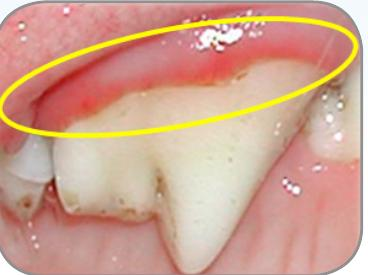

In [27]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
%cd /content/faiss_index

/content/faiss_index


In [30]:
!zip -r faiss_index.zip /content/faiss_index

  adding: content/faiss_index/ (stored 0%)
  adding: content/faiss_index/index.pkl (deflated 30%)
  adding: content/faiss_index/index.faiss (deflated 16%)


In [31]:
from google.colab import files
files.download('faiss_index.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
%cd /content/images

/content/images


In [34]:
!zip -r images.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/figure-1-2.jpg (deflated 3%)
  adding: content/images/figure-1-6.jpg (deflated 4%)
  adding: content/images/figure-1-7.jpg (deflated 3%)
  adding: content/images/figure-1-5.jpg (deflated 1%)
  adding: content/images/figure-1-1.jpg (deflated 5%)
  adding: content/images/figure-1-4.jpg (deflated 1%)
  adding: content/images/figure-1-11.jpg (deflated 4%)
  adding: content/images/figure-1-3.jpg (deflated 2%)
  adding: content/images/figure-1-9.jpg (deflated 2%)
  adding: content/images/figure-1-8.jpg (deflated 13%)
  adding: content/images/figure-1-10.jpg (deflated 3%)


In [35]:
from google.colab import files
files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>